This is a Divvy Bike (bike share) data set from Chicago. It is downloaded from [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg/data). 

The csv in the data folder has been filtered to look at only 1 pickup station: Clark and Lake. That is a busy intersection in the Loop.  

In [227]:
# Import the dataset

df = None

We will be interested in the number of Divvy rentals over any given **week** at the Clark and Lake pickup dock.  

In order to begin inspecting the data across different time intervals, we need to give our dataset a datetime index.

In [229]:
# Create datetime index based on the start time


Now that we have a datatime index, we can resample to a time frame of our choosing.

We are going from a smaller unit of time to a larger unit, so we will downsample.  With any resampling technique, we need to specify an aggregate function. In this case, we want to count the number of rides per hour.

In [231]:
# Downsample to the week and count the number of rides


Before we start looking at patterns in the data, perform a train test split.  We can't do it like we usually do. The sklearn version we use randomly picks points to assign to each set.  With time series data, we have to preserve the order, since the models depend on prior days.

We will slit of the last 52 weeks, 1 year, for our test set.

In [246]:
# Split the data so that 52 weeks are in the test set

<AxesSubplot:xlabel='START TIME'>

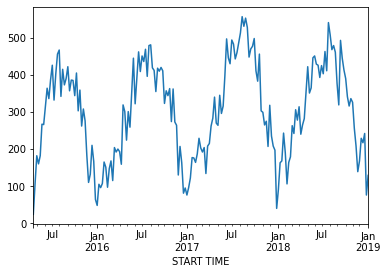

In [248]:
# Plot the training data
train.plot()

Describe the seasonality you see in the plot above.

*YOUR ANSWER HERE*

It is harder to see if there is an overall upward or downard trend. To investigate trend, let's look at the rolling mean across a year.

In [256]:
# Plot the rolling mean with a window of a year

That clearly visualizes an upward trend in our data, especially towards the first half of our dataset.

One way to remove trend this trend from the data is differencing.  A first order difference with a period of 1 (the default), will leave us with a timeseries composed of the change of rentals from 1 week to the next.

In [252]:
# Apply a 1st order difference to the time series and plot the rolling mean

The trend is much less pronounced, but still looks to be sloping downwards. Let's see if a second order difference stabilizes it further.

In [254]:
# Apply a 2nd order difference: i.e. difference the difference, and plot the rolling mean.

<AxesSubplot:xlabel='START TIME'>

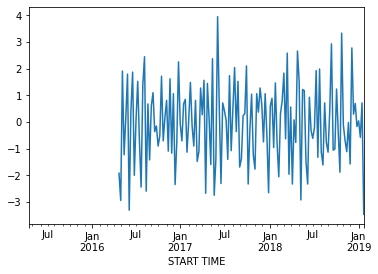

In [255]:
train_week.diff().diff().rolling(52).mean().plot()


The above eda gives us some clues about how to go about choosing the order in our SARIMAX models.  
The first choice of order will be the non-seasonal order. `p,d,q`. You can remember what those letters stand for by thinking AR=p, d=difference, MA=q.   The letters of the acronym aligns with the letters in the order argument.

In [ ]:
# Fit a SARIMAX model on the trian set with a first order difference.

In [221]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sm = SARIMAX(<your_code_here>).fit()


In [295]:
# Create a set of predictions for the train data (just use predict)

In [297]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

Next, calculate the test rmse.  To do this, you have to pass in the date of the first test element and the last test element as arguments.

The function below will print out train and test scores with a given set of orders.  

In [303]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    
    print(mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False))
    
    print(mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False))
    return sm



The function below will plot the test predictions along with the true test values.

In [304]:
def plot_predictions(test=test, sm=sm):
    
    '''
    Pass a test set, as well as a model fit to the training set 
    to this function, and plot the test predictions against
    the true test values
    '''
    
    sm.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()
    

Try out a few non-seasonal order combinations and consider the effect on the test rmse.

In [ ]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = None
plot_predictions(test, model)

The models make predictions, and different non-seasonal orders affect the rmse on the test set.  But the predictions certainly leave something to be desired.

From our eda above, we know that the data has seasonality.  We can account for this using the seasonal_order parameter.  The first step in generating better predictions is to choose the correct period.  The seasonal_order list should have for elements: P,D,Q,period (in that order).

Take the best parameters from above, then add to it a 1st order seasonal difference that makes sense with the eda.